In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
import opendatasets as od
import os 
import shutil
import torch
import torchvision.transforms as tt
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as td
import random, time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
dataset_url = 'https://www.kaggle.com/grassknoted/asl-alphabet'

In [ ]:
if os.path.exists('./asl-alphabet'):
  shutil.rmtree('./asl-alphabet')

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nithyashreem
Your Kaggle Key: ··········


100%|██████████| 1.03G/1.03G [00:28<00:00, 38.6MB/s]


In [ ]:
data_directory = './asl-alphabet/asl_alphabet_train/asl_alphabet_train'

In [ ]:
os.listdir(data_directory)

['K',
 'Q',
 'J',
 'H',
 'del',
 'P',
 'I',
 'L',
 'space',
 'nothing',
 'E',
 'O',
 'V',
 'D',
 'S',
 'Y',
 'T',
 'Z',
 'M',
 'C',
 'F',
 'B',
 'X',
 'G',
 'N',
 'W',
 'R',
 'A',
 'U']

In [ ]:
# train_data = ImageFolder(data_directory)

In [ ]:
train_data = ImageFolder(data_directory, tt.Compose([tt.Resize(128),
                                            tt.RandomCrop(128),
                                            tt.Grayscale(1),
                                            tt.ToTensor()]))

In [ ]:
len(train_data)

87000

In [ ]:
train_set_size = int(len(train_data) * 0.8)
valid_set_size = len(train_data) - train_set_size

In [ ]:
train_data, val_data = random_split(train_data, [train_set_size, valid_set_size])
len(train_data), len(val_data)

(69600, 17400)

In [ ]:
batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# PyTorch data loaders
train = DataLoader(train_data, batch_size, shuffle=True)
val = DataLoader(val_data, batch_size*2)

classes = ('A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','space','del','nothing')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.h1 = nn.Linear(1 * 128 * 128, 64) 
        self.h2 = nn.Linear(64, 128)  
        self.output = nn.Linear(128, 29)  
        self.dropout = nn.Dropout(0.3) 

    def forward(self, x):
        x = x.view(-1, 1 * 128 * 128)
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.dropout(self.output(x))

        return x

In [ ]:
num_epochs = 50

net = Net()
net.to(device)

Net(
  (h1): Linear(in_features=16384, out_features=64, bias=True)
  (h2): Linear(in_features=64, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=29, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.1, verbose=True, cooldown=10)

In [ ]:
max_accuracy = 0
train_losses = []
val_losses = []
acc_values=[]
val_accs=[]
for epoch in tqdm(range(num_epochs)):
    correct = 0
    correct_val=0
    start_time = time.time()
    train_loss = 0.0
    valid_loss = 0.0 
    
    for i, data in enumerate(train, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 
        predictions = torch.max(outputs,1)[1]
        correct+=(predictions==labels).sum().cpu().numpy()

    with torch.no_grad():
        for i, data in enumerate(val, 0):
            val_inputs, val_labels = data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            net.eval()
            val_preds = net(val_inputs)
            loss = criterion(val_preds, val_labels)
            valid_loss += loss.item()
            val_predictions = torch.max(val_preds, 1)[1]
            correct_val+=(val_predictions==val_labels).sum().cpu().numpy()

    acc = 100*correct/len(train.dataset)
    acc_values.append(acc)

    val_acc = 100*correct_val/len(val.dataset)
    val_accs.append(val_acc)

    train_losses.append(train_loss/len(train.dataset))
    val_losses.append(valid_loss/ len(val.dataset))

    print('Epoch %s , Training acc: %f, Validation acc: %f' %(epoch+1, acc, val_acc))

  2%|▏         | 1/50 [02:03<1:41:07, 123.84s/it]

Epoch 1 , Training acc: 6.126437, Validation acc: 7.166667


  4%|▍         | 2/50 [04:06<1:38:34, 123.22s/it]

Epoch 2 , Training acc: 8.215517, Validation acc: 8.988506


  6%|▌         | 3/50 [06:11<1:37:16, 124.17s/it]

Epoch 3 , Training acc: 9.310345, Validation acc: 10.781609


  8%|▊         | 4/50 [08:14<1:34:38, 123.44s/it]

Epoch 4 , Training acc: 10.501437, Validation acc: 11.925287


 10%|█         | 5/50 [10:16<1:32:13, 122.96s/it]

Epoch 5 , Training acc: 11.778736, Validation acc: 13.574713


 12%|█▏        | 6/50 [12:18<1:29:56, 122.64s/it]

Epoch 6 , Training acc: 12.643678, Validation acc: 15.568966


 14%|█▍        | 7/50 [14:20<1:27:43, 122.40s/it]

Epoch 7 , Training acc: 13.295977, Validation acc: 13.925287


 16%|█▌        | 8/50 [16:22<1:25:34, 122.26s/it]

Epoch 8 , Training acc: 14.764368, Validation acc: 15.132184


 18%|█▊        | 9/50 [18:24<1:23:35, 122.34s/it]

Epoch 9 , Training acc: 15.382184, Validation acc: 13.643678


 20%|██        | 10/50 [20:26<1:21:32, 122.31s/it]

Epoch 10 , Training acc: 15.531609, Validation acc: 19.270115


 22%|██▏       | 11/50 [22:28<1:19:25, 122.18s/it]

Epoch 11 , Training acc: 16.528736, Validation acc: 19.166667


 24%|██▍       | 12/50 [24:29<1:17:06, 121.75s/it]

Epoch 12 , Training acc: 18.156609, Validation acc: 15.396552


 26%|██▌       | 13/50 [26:30<1:14:56, 121.53s/it]

Epoch 13 , Training acc: 18.793103, Validation acc: 16.436782


 28%|██▊       | 14/50 [28:31<1:12:48, 121.34s/it]

Epoch 14 , Training acc: 19.301724, Validation acc: 15.856322


 30%|███       | 15/50 [30:32<1:10:44, 121.26s/it]

Epoch 15 , Training acc: 20.040230, Validation acc: 22.494253


 32%|███▏      | 16/50 [32:33<1:08:41, 121.23s/it]

Epoch 16 , Training acc: 20.405172, Validation acc: 12.770115


 34%|███▍      | 17/50 [34:34<1:06:35, 121.06s/it]

Epoch 17 , Training acc: 20.823276, Validation acc: 20.402299


 36%|███▌      | 18/50 [36:35<1:04:35, 121.12s/it]

Epoch 18 , Training acc: 20.535920, Validation acc: 23.816092


 38%|███▊      | 19/50 [38:37<1:02:36, 121.18s/it]

Epoch 19 , Training acc: 21.640805, Validation acc: 23.189655


 40%|████      | 20/50 [40:38<1:00:34, 121.15s/it]

Epoch 20 , Training acc: 22.034483, Validation acc: 19.873563


 42%|████▏     | 21/50 [42:39<58:36, 121.25s/it]  

Epoch 21 , Training acc: 21.962644, Validation acc: 21.522989


 44%|████▍     | 22/50 [44:41<56:36, 121.31s/it]

Epoch 22 , Training acc: 22.847701, Validation acc: 24.580460


 46%|████▌     | 23/50 [46:42<54:36, 121.36s/it]

Epoch 23 , Training acc: 22.510057, Validation acc: 11.149425


 48%|████▊     | 24/50 [48:45<52:51, 121.98s/it]

Epoch 24 , Training acc: 22.510057, Validation acc: 25.551724


 50%|█████     | 25/50 [50:47<50:47, 121.89s/it]

Epoch 25 , Training acc: 22.593391, Validation acc: 26.517241


 52%|█████▏    | 26/50 [52:49<48:43, 121.79s/it]

Epoch 26 , Training acc: 22.929598, Validation acc: 22.160920


 54%|█████▍    | 27/50 [54:51<46:41, 121.82s/it]

Epoch 27 , Training acc: 23.668103, Validation acc: 25.729885


 56%|█████▌    | 28/50 [56:52<44:38, 121.75s/it]

Epoch 28 , Training acc: 22.614943, Validation acc: 22.649425


 58%|█████▊    | 29/50 [58:54<42:37, 121.79s/it]

Epoch 29 , Training acc: 23.958333, Validation acc: 25.379310


 60%|██████    | 30/50 [1:00:56<40:35, 121.76s/it]

Epoch 30 , Training acc: 23.227011, Validation acc: 12.235632


 62%|██████▏   | 31/50 [1:02:57<38:33, 121.74s/it]

Epoch 31 , Training acc: 24.390805, Validation acc: 19.770115


 64%|██████▍   | 32/50 [1:04:59<36:32, 121.78s/it]

Epoch 32 , Training acc: 24.097701, Validation acc: 24.896552


 66%|██████▌   | 33/50 [1:07:01<34:29, 121.72s/it]

Epoch 33 , Training acc: 24.291667, Validation acc: 26.218391


 68%|██████▊   | 34/50 [1:09:02<32:26, 121.63s/it]

Epoch 34 , Training acc: 23.668103, Validation acc: 25.362069


 70%|███████   | 35/50 [1:11:04<30:23, 121.55s/it]

Epoch 35 , Training acc: 24.300287, Validation acc: 28.310345


 72%|███████▏  | 36/50 [1:13:05<28:18, 121.35s/it]

Epoch 36 , Training acc: 23.816092, Validation acc: 22.379310


 74%|███████▍  | 37/50 [1:15:06<26:16, 121.27s/it]

Epoch 37 , Training acc: 24.353448, Validation acc: 20.063218


 76%|███████▌  | 38/50 [1:17:07<24:14, 121.20s/it]

Epoch 38 , Training acc: 24.548851, Validation acc: 22.787356


 78%|███████▊  | 39/50 [1:19:07<22:11, 121.04s/it]

Epoch 39 , Training acc: 25.043103, Validation acc: 16.706897


 80%|████████  | 40/50 [1:21:08<20:10, 121.03s/it]

Epoch 40 , Training acc: 24.767241, Validation acc: 26.448276


 82%|████████▏ | 41/50 [1:23:10<18:09, 121.06s/it]

Epoch 41 , Training acc: 25.943966, Validation acc: 24.908046


 84%|████████▍ | 42/50 [1:25:11<16:08, 121.12s/it]

Epoch 42 , Training acc: 24.666667, Validation acc: 14.350575


 86%|████████▌ | 43/50 [1:27:12<14:08, 121.20s/it]

Epoch 43 , Training acc: 25.182471, Validation acc: 22.925287


 88%|████████▊ | 44/50 [1:29:13<12:07, 121.17s/it]

Epoch 44 , Training acc: 25.425287, Validation acc: 27.471264


 90%|█████████ | 45/50 [1:31:15<10:06, 121.25s/it]

Epoch 45 , Training acc: 25.206897, Validation acc: 28.718391


 92%|█████████▏| 46/50 [1:33:16<08:05, 121.28s/it]

Epoch 46 , Training acc: 25.159483, Validation acc: 26.264368


 94%|█████████▍| 47/50 [1:35:17<06:03, 121.27s/it]

Epoch 47 , Training acc: 26.413793, Validation acc: 18.919540


 96%|█████████▌| 48/50 [1:37:18<04:02, 121.13s/it]

Epoch 48 , Training acc: 25.441092, Validation acc: 27.103448


 98%|█████████▊| 49/50 [1:39:19<02:01, 121.15s/it]

Epoch 49 , Training acc: 25.579023, Validation acc: 24.902299


100%|██████████| 50/50 [1:41:20<00:00, 121.61s/it]

Epoch 50 , Training acc: 26.133621, Validation acc: 21.040230


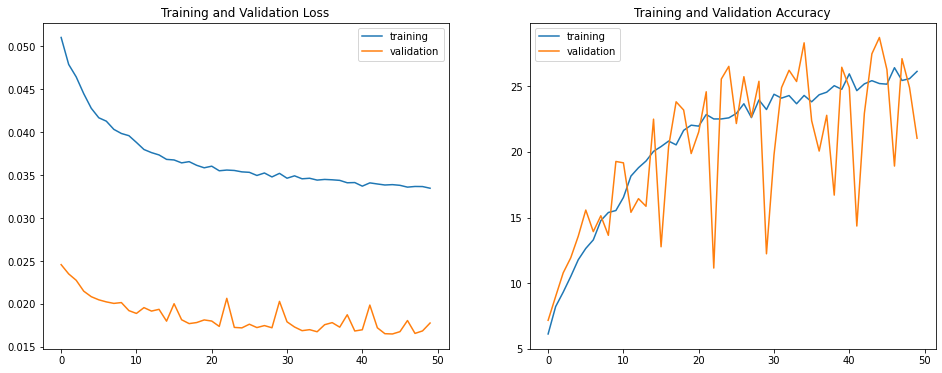

In [ ]:
fig, _ = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

fig.axes[0].plot(train_losses, label="training")
fig.axes[0].plot(val_losses, label="validation")
fig.axes[0].set_title("Training and Validation Loss")
fig.axes[0].legend()
fig.axes[1].plot(acc_values, label="training")
fig.axes[1].plot(val_accs, label="validation")
fig.axes[1].set_title("Training and Validation Accuracy")
fig.axes[1].legend()

In [ ]:
torch.save(net.state_dict(), 'linear.pth')

In [ ]:
data_dir = '/content/asl-alphabet/asl_alphabet_test'
test_data = ImageFolder(data_dir, tt.Compose([tt.Resize(128),
                                            tt.RandomCrop(128),
                                            tt.Grayscale(1),
                                            tt.ToTensor()]))
test = DataLoader(test_data)
correct=[]
wrong=[]
with torch.no_grad():
  correct_val=0
  for i, data in enumerate(test, 0):
    test_inputs, test_labels = data
    test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
    net.eval()
    test_preds = net(test_inputs)
    test_predictions = torch.max(test_preds, 1)[1]
    correct_val+=(test_predictions==test_labels).sum().cpu().numpy()
    if test_predictions==test_labels:
      correct.append(i)
    else:
      wrong.append(i)

print("The test accuracy over %s samples is %f" %(len(test), correct_val/len(test.dataset)*100))

The test accuracy over 28 samples is 25.000000


In [ ]:
correct

[0, 1, 2, 3, 4, 5, 26]

In [ ]:
wrong

[6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 27]